# Improving labelling accuracy in commercial wearable devices- Apple Watch and Fitbit

Problem Statement: Can I make a model that proves that wearables are appropriate to track the activities of a population.

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report

In [13]:
df = pd.read_csv('./data/aw_fb_data.csv')

In [14]:
df.head()

,Unnamed: 0,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,device,activity
0,1,1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.000000,19.531302,0.138520,1.000000,0.089692,apple watch,Lying
1,2,2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.000000,19.453390,0.137967,1.000000,0.102088,apple watch,Lying
2,3,3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.000000,19.540825,0.138587,1.000000,0.115287,apple watch,Lying
3,4,4,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,6.221612,6.116349,59.0,1.000000,19.628260,0.139208,1.000000,0.129286,apple watch,Lying
4,5,5,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,6.221612,6.116349,59.0,0.982816,19.715695,0.139828,0.241567,0.144088,apple watch,Lying


## Data cleaning

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   X1                    6264 non-null   int64  
 1   age                   6264 non-null   int64  
 2   gender                6264 non-null   int64  
 3   height                6264 non-null   float64
 4   weight                6264 non-null   float64
 5   steps                 6264 non-null   float64
 6   heart_rate            6264 non-null   float64
 7   calories              6264 non-null   float64
 8   distance              6264 non-null   float64
 9   entropy_heart         6264 non-null   float64
 10  entropy_steps         6264 non-null   float64
 11  resting_heart         6264 non-null   float64
 12  corr_heart_steps      6264 non-null   float64
 13  norm_heart            6264 non-null   float64
 14  intensity_karvonen    6264 non-null   float64
 15  sd_norm_heart        

In [38]:
df = df.drop(columns='Unnamed: 0')

Fixing typos

In [39]:
df = df.rename(columns = {'hear_rate':'heart_rate', 'entropy_setps': 'entropy_steps'})

## EDA

In [35]:
df['device'].value_counts(normalize = True)

apple watch    0.583653
fitbit         0.416347
Name: device, dtype: float64

In [54]:
df.groupby('device')['activity'].value_counts(normalize = True)

device       activity      
apple watch  Lying             0.215263
             Running 7 METs    0.167670
             Running 5 METs    0.164934
             Running 3 METs    0.156455
             Sitting           0.150985
             Self Pace walk    0.144694
fitbit       Lying             0.226994
             Running 7 METs    0.192101
             Running 5 METs    0.152991
             Running 3 METs    0.144939
             Sitting           0.144939
             Self Pace walk    0.138037
Name: activity, dtype: float64

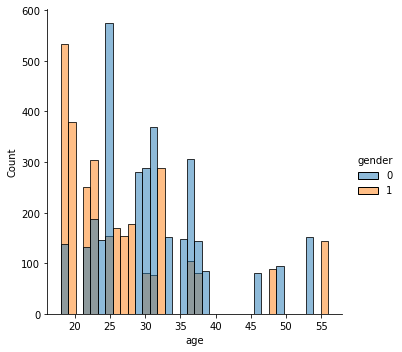

In [45]:
sns.displot(data = df, x = 'age', hue= 'gender')

The summary of the sample's demographic:


In [60]:
df.describe()

,X1,age,gender,height,weight,steps,heart_rate,calories,distance,entropy_heart,entropy_steps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance
count,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000
mean,1771.144317,29.158525,0.476533,169.709052,69.614464,109.562268,86.142331,19.471823,13.832555,6.030314,5.739984,65.869938,0.306447,20.272393,0.155479,8.110854,590.035239
std,1097.988748,8.908978,0.499489,10.324698,13.451878,222.797908,28.648385,27.309765,45.941437,0.765574,1.256348,21.203017,0.775418,28.388116,0.210927,12.535080,4063.838530
min,1.000000,18.000000,0.000000,143.000000,43.000000,1.000000,2.222222,0.056269,0.000440,0.000000,0.000000,3.000000,-1.000000,-76.000000,-2.714286,0.000000,0.000690
25%,789.750000,23.000000,0.000000,160.000000,60.000000,5.159534,75.598079,0.735875,0.019135,6.108524,5.909440,58.134333,-0.467303,1.148883,0.009819,0.264722,0.659260
50%,1720.000000,28.000000,0.000000,168.000000,68.000000,10.092029,77.267680,4.000000,0.181719,6.189825,6.157197,75.000000,0.665829,9.820254,0.079529,2.893503,13.368619
75%,2759.250000,33.000000,1.000000,180.000000,77.300000,105.847222,95.669118,20.500000,15.697188,6.247928,6.247928,76.138701,1.000000,27.077336,0.211868,9.679672,93.728562
max,3670.000000,56.000000,1.000000,191.000000,115.000000,1714.000000,194.333333,97.500000,335.000000,6.475733,6.475733,155.000000,1.000000,156.319444,1.297980,74.457929,51520.000000


## characteristics of activities (not fixed)

Using intuition, the intensity of each activity should be ranked by the following:
1. Running 7 MET
2. Running 5 MET
3. Running 3 MET
4. Self paced walk
5. Sitting
6. Lying

In [147]:
#plotting groupby activities
def plot_activities(metric):
    group = df.groupby('activity')[metric].mean()
    group.plot(kind = 'bar', title = metric, ylabel= f'Mean {metric}', xlabel = 'activity')
    

#### steps

In [140]:
grouped['steps'].mean()

activity
Lying              96.853795
Running 3 METs     94.572186
Running 5 METs    111.964060
Running 7 METs    139.742256
Self Pace walk     81.005634
Sitting           132.277651
Name: steps, dtype: float64

Sitting detects an alarmingly high amount of steps

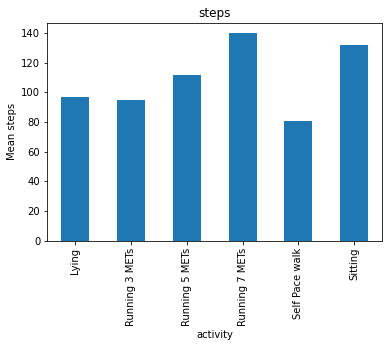

In [130]:
plot_activities('steps')

In [103]:
df.groupby('device')['steps'].mean()

device
apple watch    180.246421
fitbit          10.474360
Name: steps, dtype: float64

In [84]:
df[df['activity'] == 'Sitting'].groupby('device')['steps'].mean()

device
apple watch    216.130231
fitbit           9.826265
Name: steps, dtype: float64

#### heart rate

In [85]:
df.groupby('activity')['heart_rate'].mean()

activity
Lying             79.389118
Running 3 METs    85.125682
Running 5 METs    91.104565
Running 7 METs    97.756087
Self Pace walk    82.575124
Sitting           81.346485
Name: heart_rate, dtype: float64

Self paced walking had very similar heart rates to lying and sitting, indicating that the walking activity wasn't very demanding. 

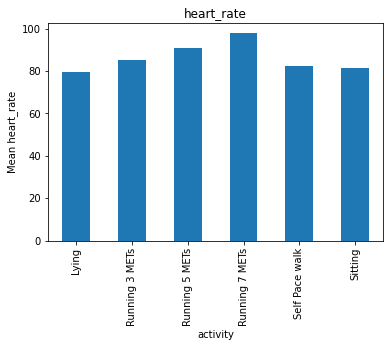

In [131]:
plot_activities('heart_rate')

#### calories

In [86]:
df.groupby('activity')['calories'].mean()

activity
Lying              7.923465
Running 3 METs    28.102023
Running 5 METs    30.262551
Running 7 METs    16.538612
Self Pace walk    27.988315
Sitting           11.526257
Name: calories, dtype: float64

Calories burnt doesn't seem to reflect the truth when performing a 7MET run 

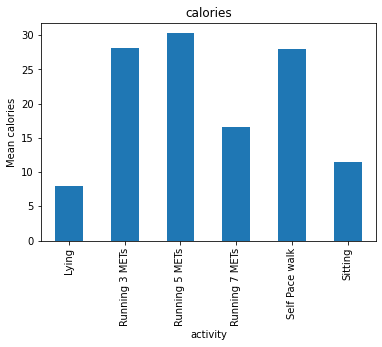

In [132]:
plot_activities('calories')

#### distance

In [90]:
df.groupby('activity')['distance'].mean()

activity
Lying             11.743491
Running 3 METs    12.749358
Running 5 METs    13.544277
Running 7 METs    16.802184
Self Pace walk    15.151113
Sitting           13.529701
Name: distance, dtype: float64

Distance reflects the correct amount for running and walking activities but lying and sitting has also recorded high amounts of distance. 

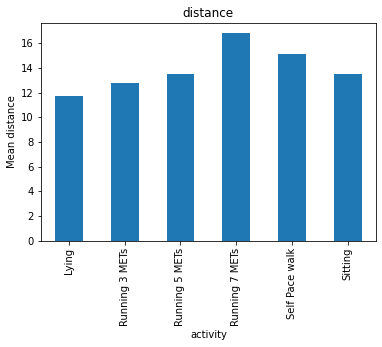

In [141]:
plot_activities('distance')

In [111]:
df.groupby('activity')['entropy_heart'].mean()

activity
Lying             5.950982
Running 3 METs    6.132183
Running 5 METs    6.133575
Running 7 METs    5.825008
Self Pace walk    6.123235
Sitting           6.089736
Name: entropy_heart, dtype: float64

#### other variables

heart and step entropy are just to confirm consistency in the data

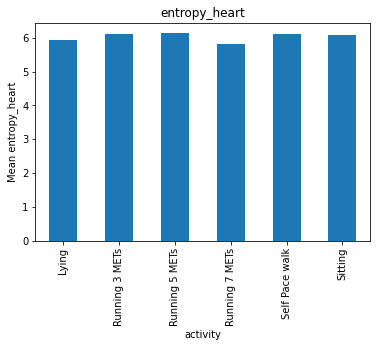

In [142]:
plot_activities('entropy_heart')

In [112]:
df.groupby('activity')['entropy_steps'].mean()

activity
Lying             5.641916
Running 3 METs    5.936568
Running 5 METs    5.896102
Running 7 METs    5.386054
Self Pace walk    5.845467
Sitting           5.839507
Name: entropy_steps, dtype: float64

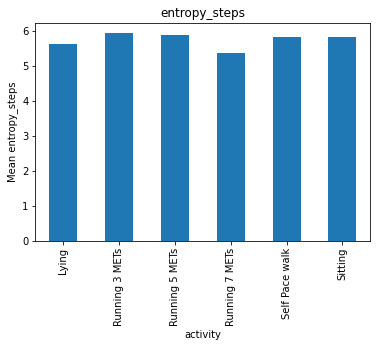

In [144]:
plot_activities('entropy_steps')

#### Karvonen Intensity

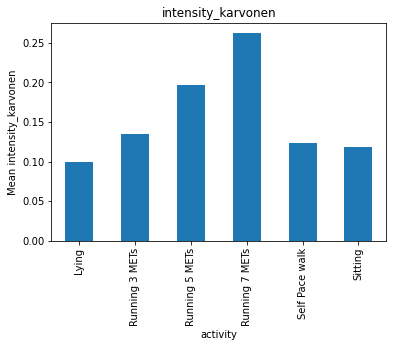

In [145]:
plot_activities('intensity_karvonen')

#### Calories vs heart_rate

heart rate is not an indicator of burnt calories

Text(0.5, 1.0, 'Calories vs Heart Rate')

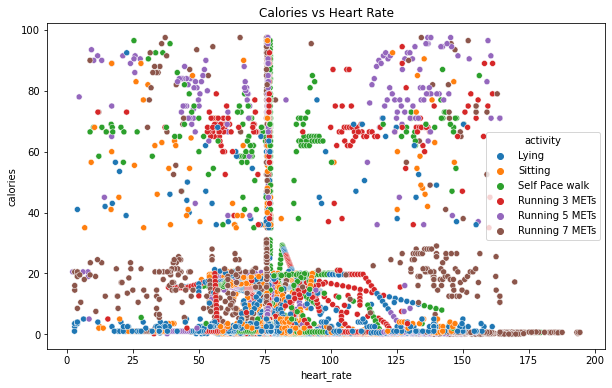

In [177]:
plt.figure(figsize = (10,6))
sns.scatterplot(data= df, x= 'heart_rate', y = 'calories', hue = 'activity')
plt.title('Calories vs Heart Rate')

#### Heart rate and steps

There seems to be a posisive relationship between heart_rate and steps as expected

Text(0.5, 1.0, 'Steps vs Heart Rate')

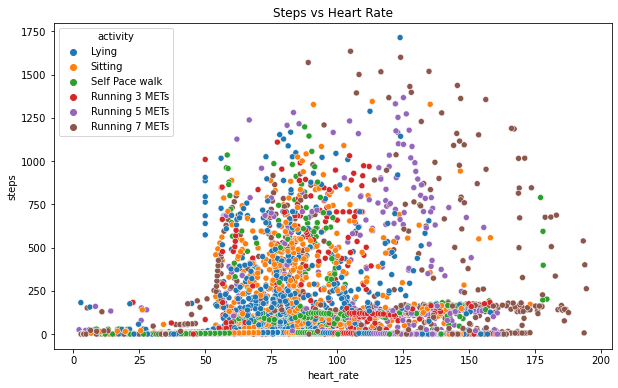

In [175]:
plt.figure(figsize = (10,6))
sns.scatterplot(data= df, x= 'heart_rate', y = 'steps', hue = 'activity')
plt.title('Steps vs Heart Rate')

#### steps and distance

Text(0.5, 1.0, 'Steps vs distance')

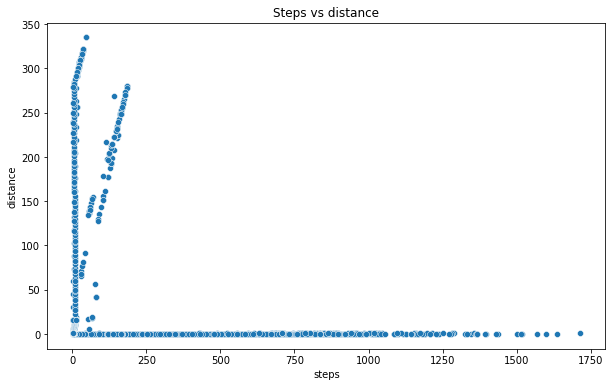

In [247]:
plt.figure(figsize = (10,6))
sns.scatterplot(data= df, x= 'steps', y = 'distance')
plt.title('Steps vs distance')

#### resting heart rate

<AxesSubplot:ylabel='Frequency'>

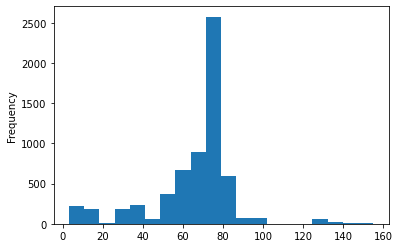

In [170]:
df['resting_heart'].plot(kind= 'hist', bins = 20)

## Feature engineering

#### Creating BMI column

In [162]:
df['height'] = df['height']/100

In [163]:
df['BMI'] = df['weight']/df['height']**2

The BMI of the sample group seem to have 2 outliers. I've chosen to keep them as the watch should be worn by any individual and because I won't be using parametric models.

<AxesSubplot:ylabel='Frequency'>

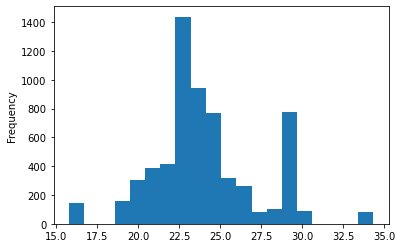

In [169]:
df['BMI'].plot(kind= 'hist', bins = 20)

### binarizing 'device'
1 = apple watch
0 = fitbit

In [171]:
df['device'] = df['device'].map({'apple watch': 1, 'fitbit': 0})

## Pre-processing

Entropy isn't relevant to predicting activities as it is just an indication of regularity in the data. Decided to keep the engineered features.

In [173]:
X = df.drop(columns = ['X1', 'entropy_heart', 'entropy_steps','activity'])
y = df['activity']

### Train test split

shuffle = False because this data is a time series

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                 random_state = 9,
                                                    shuffle = False
                                                 )

## Modelling

#### Random Forest

In [198]:
r_forest = RandomForestClassifier()

In [204]:
r_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [232]:
forest_params = {
    'max_depth': [10,25,50,100,200],
    'n_estimators': [200,300,500]
}

In [233]:
forest_gs = GridSearchCV(rfc,
                         forest_params,
                         cv= 5,
                         verbose = 1)

In [234]:
forest_gs.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 25, 50, 100, 200],
                         'n_estimators': [200, 300, 500]},
             verbose=1)

In [235]:
forest_gs.best_params_

{'max_depth': 100, 'n_estimators': 300}

In [236]:
forest_gs.best_score_

0.5406578667192037

## Evaluation

#### Baseline accuracy score
baseline = x**2 + x1**2...

In [237]:
base = y.value_counts(normalize = True).to_frame()
base['activity'].map(lambda x: x**2).sum()

0.17086533317348707

#### Accuracy scores

Evidence of some bias

In [238]:
forest_gs.best_score_

0.5406578667192037

In [239]:
forest_gs.score(X_test, y_test)

0.5714285714285714

#### Confusion matrix

In [240]:
y_pred = forest_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

In [241]:
activities = ['Lying', 'Running 3 METs', 'Running 5 METs', 'Running 7 METs', 'Self Pace walk', 'Sitting']

In [242]:
cm_df = pd.DataFrame(cm,
                     index = activities, 
                     columns = activities)

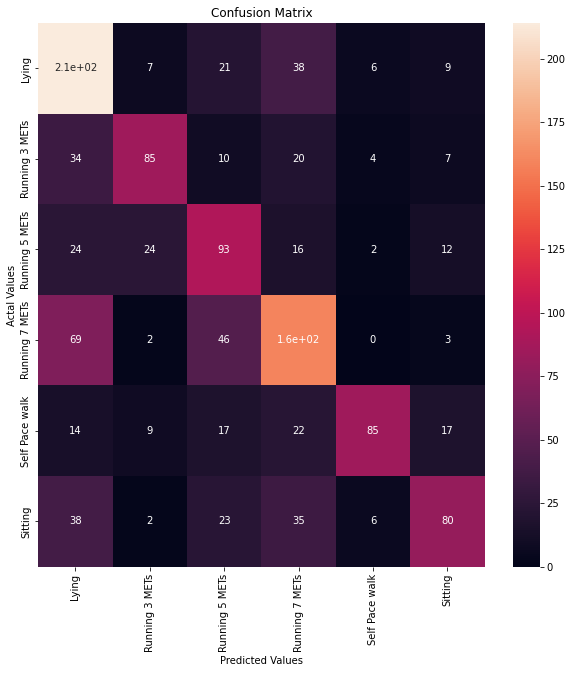

In [243]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

The model was able to correctly label the 'self pace walking' a lot better than any other activity.

In [244]:
print(classification_report(y_test, y_pred, target_names=activities))

                precision    recall  f1-score   support

         Lying       0.54      0.73      0.62       295
Running 3 METs       0.66      0.53      0.59       160
Running 5 METs       0.44      0.54      0.49       171
Running 7 METs       0.55      0.57      0.56       279
Self Pace walk       0.83      0.52      0.64       164
       Sitting       0.62      0.43      0.51       184

      accuracy                           0.57      1253
     macro avg       0.61      0.55      0.57      1253
  weighted avg       0.59      0.57      0.57      1253

